# Counting objects in bins at Amazon Distribution Center
This notebook is used to download the dataset from its source, preprocess it and upload it to Amazon S3 bucket, for later use when training the algorithm. The Amazon SageMaker Estimator is also created here to orchestrate the model training and deployment processes.

In [5]:
# Install all the  packages needed
!pip install smdebug
!pip install torchvision --no-cache-dir
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 23.3 MB 19.1 MB/s            
     |████████████████████████████████| 881.9 MB 45.2 MB/s            
/opt/conda/lib/python3.7/site-packages/secr

In [6]:
# Import any packages that you might need
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
import os
import json
import re
import shutil
from tqdm import tqdm
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython
from torchvision import datasets, transforms
import torch
import numpy as np

In [7]:
# create sagemaker session, execution role and the default bucket we will use to store data in
session = sagemaker.Session()

role = sagemaker.get_execution_role()

bucket= session.default_bucket()

os.environ["DEFAULT_S3_BUCKET"] = bucket

## Dataset

### Dataset statistics

In [2]:
# Download files required for computing the stats
!curl -O "http://www.cs.unc.edu/~eunbyung/abidc/metadata.json"
!curl -O "http://www.cs.unc.edu/~eunbyung/abidc/instances.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  639M  100  639M    0     0  21.6M      0  0:00:29  0:00:29 --:--:-- 21.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.6M  100 75.6M    0     0  21.8M      0  0:00:03  0:00:03 --:--:-- 21.8M


loading metadata...
loading instance list...
loading metadata and instances finished!
Statistics!
Total Images: 535234
Average expected quantity in a bin: 2736719/535234: 5.113126221428384
The number of instances: 459558
Showing histogram of repeatition


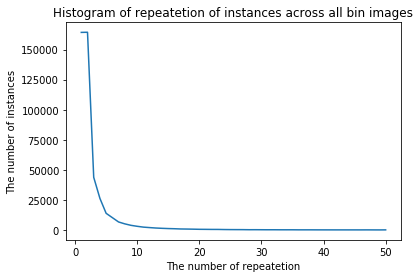

Showing histogram of quantity distribution


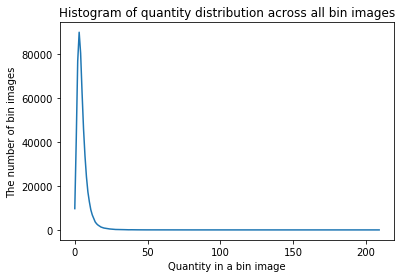

In [11]:
# Execute script that generates the stats and EDA for the dataset
import matplotlib.pyplot as plt
%matplotlib inline
%run data_stats.py

### Dataset Preparation
Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('dataset/train', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:46,  7.37it/s]

  2%|▏         | 24/1228 [00:02<02:01,  9.88it/s]


KeyboardInterrupt: 

In [ ]:
# Slice the validation dataset from the downloaded data
os.makedirs('dataset/val')
classes = os.listdir('dataset/train')
for class_name in classes:
    class_path = os.path.join('dataset/train', class_name)
    val_length = int(len(os.listdir(class_path)) * 0.2) # validation dataset should account for 20% of the whole   
    file_counter = 0
    files = os.listdir(class_path)
    for file in files:
        if file_counter < val_length:
            os.makedirs(os.path.join('dataset/val', class_name), exist_ok=True)
            shutil.move(os.path.join(class_path, file), os.path.join('dataset/val', class_name, file))
            file_counter += 1

In [27]:
# Upload the data to AWS S3
!aws s3 sync ./dataset s3://${DEFAULT_S3_BUCKET}/capstone_project/dataset

983
245
upload: dataset/train/1/00035.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00035.jpg
upload: dataset/train/1/00024.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00024.jpg
upload: dataset/train/1/00148.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00148.jpg
upload: dataset/train/1/00084.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00084.jpg
upload: dataset/train/1/00214.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00214.jpg
upload: dataset/train/1/00194.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00194.jpg
upload: dataset/train/1/00232.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00232.jpg
upload: dataset/train/1/00289.jpg to s3://sagemaker-us-east-1-547231615587/capstone_project/dataset/train/1/00289.jpg
upload: dataset/train/1/00284.jpg to s3://sagema

## Hyperparameter Tuning

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. Follow [this](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) link to learn how it works.

In [11]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128, 256]),
    "epochs": IntegerParameter(2, 4)
} 

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"},
    {"Name": "trainging loss", "Regex": "Loss: ([0-9\\.]+)"},
    {"Name": "test accuracy", "Regex": "Accuracy: ([0-9\\.]+)"}
]

In [12]:
# Create estimators for your HPs
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.4xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
) 

In [13]:
tuner.fit()

...................................................................................................................................................................................................................................................................................................................................................................!


In [17]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-12 14:25:46 Starting - Preparing the instances for training
2022-01-12 14:25:46 Downloading - Downloading input data
2022-01-12 14:25:46 Training - Training image download completed. Training in progress.
2022-01-12 14:25:46 Uploading - Uploading generated training model
2022-01-12 14:25:46 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '2',
 'lr': '0.00472944371548418',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-12-14-06-34-734"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-547231615587/pytorch-training-2022-01-12-14-06-34-734/source/sourcedir.tar.gz"'}

## SageMaker Debugger Profiling
Amazon SageMaker Debugger provides full visibility into training jobs of state-of-the-art machine learning models. 
- Use the Debugger built-in rules provided by Amazon SageMaker Debugger and analyze tensors emitted while training your models. The Debugger built-in rules monitor various common conditions that are critical for the success of a training job. 
- ProfilerConfig provides Configuration information for Debugger system monitoring, framework profiling, and storage paths.
- Debugger saves the model training output tensors into the default S3 bucket. The format of the default S3 bucket URI is s3://sagemaker-<region>-<12digit_account_id>/<training-job-name>/debug-output/.

In [20]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

## Model Training

In [31]:
# Declare the model training hyperparameter.
best_job_params = best_estimator.hyperparameters()
best_hyperparameters = {'epochs': best_job_params['epochs'], 'batch-size': int(best_job_params['batch-size'].strip('"')), 'lr': best_job_params['lr']} 

In [80]:
# Create the  training estimator
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [81]:
# Fit your estimator
estimator.fit(wait=True)

2022-01-12 20:51:01 Starting - Starting the training job...
2022-01-12 20:51:27 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-01-12 20:52:27 Starting - Preparing the instances for training.........
2022-01-12 20:53:57 Downloading - Downloading input data
2022-01-12 20:53:57 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-12 20:54:38,580 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-12 20:54:38,582 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-12 20:54:38,589 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-12 20:54:44,814 

Plot the debugger output

In [82]:
session = boto3.session.Session()
region = session.region_name

# estimator = PyTorch.attach('pytorch-training-2022-01-12-18-25-59-495')
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
# trial = create_trial('s3://sagemaker-us-east-1-547231615587/pytorch-training-2022-01-12-18-25-59-495/debug-output/')
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

Training jobname: pytorch-training-2022-01-12-20-51-00-709
Region: us-east-1
[2022-01-12 21:12:07.949 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-547231615587/pytorch-training-2022-01-12-20-51-00-709/debug-output
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'la

In [83]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-547231615587/pytorch-training-2022-01-12-20-51-00-709/rule-output


## Model Deploying

In [84]:
# Deploy your model to an endpoint
# predictor = Predictor('pytorch-training-2021-12-27-19-48-46-827') # if kernel was dead, create predictor from endpoint name
from sagemaker.predictor import Predictor
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:     2    2    1    3
Predicted:     1    4    4    4


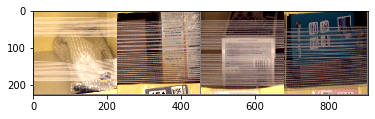

In [85]:
#Run an prediction on the endpoint
def create_data_loaders(data, batch_size):
    '''
    This is an optional function that you may or may not need to implement
    depending on whether you need to use data loaders or not
    '''
    return torch.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True
    )


def imshow(img):
    import numpy as np
    import matplotlib.pyplot as plt
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

testset = datasets.ImageFolder(os.path.join('dataset', "val"), transforms.Compose(
    [   
        transforms.Resize(size=(256, 256)),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
))
testloader = create_data_loaders(testset, 4)
dataiter = iter(testloader)
images, labels = dataiter.next()

outputs = predictor.predict(images)
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)


import torchvision
imshow(torchvision.utils.make_grid(images))
classes = (1, 2, 3, 4, 5)
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))
                                       
print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

Inference without DataLoader

In [ ]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})
type(response2[0][0])
response2[0]
import torch
import numpy as np
np.argmax(response, 1) 

In [ ]:
# predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances